# Cavern storage capacity

In [1]:
import os

import cartopy.crs as ccrs
import contextily as cx
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib_scalebar.scalebar import ScaleBar

from h2ss import capacity as cap
from h2ss import data as rd
from h2ss import functions as fns

In [2]:
# basemap cache directory
cx.set_cache_dir(os.path.join("data", "basemaps"))

## Halite data

In [3]:
ds, extent = rd.kish_basin_data_depth_adjusted(
    dat_path=os.path.join("data", "kish-basin"),
    bathymetry_path=os.path.join("data", "bathymetry"),
)

In [4]:
xmin, ymin, xmax, ymax = extent.total_bounds

## Constraints

### Exploration wells

In [5]:
# 500 m buffer - suggested in draft OREDP II p. 108
wells, wells_b = fns.constraint_exploration_well(
    data_path=os.path.join(
        "data",
        "exploration-wells",
        "Exploration_Wells_Irish_Offshore.shapezip.zip",
    )
)

### Wind farms

In [6]:
# the shapes are used as is without a buffer - suggested for renewable energy
# test site areas in draft OREDP II p. 109
wind_farms = fns.constraint_wind_farm(
    data_path=os.path.join(
        "data", "wind-farms", "wind-farms-foreshore-process.zip"
    ),
    dat_extent=extent,
)

### Frequent shipping routes

In [7]:
# 1 NM (1,852 m) buffer - suggested in draft OREDP II p. 108
shipping, shipping_b = fns.constraint_shipping_routes(
    data_path=os.path.join(
        "data", "shipping", "shipping_frequently_used_routes.zip"
    ),
    dat_extent=extent,
)

### Shipwrecks

In [8]:
# Archaeological Exclusion Zones recommendation - 100 m buffer
shipwrecks, shipwrecks_b = fns.constraint_shipwrecks(
    data_path=os.path.join(
        "data", "shipwrecks", "IE_GSI_MI_Shipwrecks_IE_Waters_WGS84_LAT.zip"
    ),
    dat_extent=extent,
)

### Subsea cables

In [9]:
# 750 m buffer - suggested in draft OREDP II p. 109-111
cables, cables_b = fns.constraint_subsea_cables(
    data_path=os.path.join("data", "subsea-cables", "KIS-ORCA.gpkg")
)

### Distance from salt formation edge

In [10]:
edge_buffer = fns.constraint_halite_edge(dat_xr=ds)

## Zones of interest

In [11]:
# height = 85 m, 500 m <= depth <= 2,000 m, diameter = 80 m,
# separation = 320 m
zones, zds = fns.zones_of_interest(
    dat_xr=ds, constraints={"height": 85, "min_depth": 500, "max_depth": 2000}
)

## Generate caverns

In [12]:
caverns, caverns_excl = fns.generate_caverns_with_constraints(
    zones_gdf=zones,
    zones_ds=zds,
    dat_extent=extent,
    exclusions={
        "wells": wells_b,
        "wind_farms": wind_farms,
        "shipwrecks": shipwrecks_b,
        "shipping": shipping_b,
        "cables": cables_b,
        "edge": edge_buffer,
    },
)

Without constraints...
Number of potential caverns: 4,169
------------------------------------------------------------
Exclude salt formation edges...
Number of potential caverns: 4,084
Caverns excluded: 2.04%
------------------------------------------------------------
Exclude frequent shipping routes...
Number of potential caverns: 1,776
Caverns excluded: 57.40%
------------------------------------------------------------
Exclude subsea cables...
Number of potential caverns: 1,708
Caverns excluded: 59.03%
------------------------------------------------------------
Exclude wind farms...
Number of potential caverns: 1,348
Caverns excluded: 67.67%
------------------------------------------------------------
Exclude exploration wells...
Number of potential caverns: 1,348
Caverns excluded: 67.67%
------------------------------------------------------------
Exclude shipwrecks...
Number of potential caverns: 1,348
Caverns excluded: 67.67%
---------------------------------------------------

In [13]:
# label caverns by height and depth
caverns = fns.label_caverns(
    cavern_df=caverns,
    heights=[85, 155, 311],
    depths={"min": 500, "min_opt": 1000, "max_opt": 1500, "max": 2000},
)

## Capacity

### Volume

In [14]:
caverns["cavern_volume"] = cap.cavern_volume(height=caverns["cavern_height"])
caverns["cavern_volume"] = cap.corrected_cavern_volume(
    v_cavern=caverns["cavern_volume"]
)

### Mid-point temperature

In [15]:
caverns["t_mid_point"] = cap.temperature_cavern_mid_point(
    height=caverns["cavern_height"], depth_top=caverns["cavern_depth"]
)

### Operating pressure

In [16]:
(
    caverns["p_operating_min"],
    caverns["p_operating_max"],
) = cap.pressure_operating(thickness_overburden=caverns["TopDepthSeabed"])

### Hydrogen gas density

In [17]:
caverns["rho_min"], caverns["rho_max"] = cap.density_hydrogen_gas(
    p_operating_min=caverns["p_operating_min"],
    p_operating_max=caverns["p_operating_max"],
    t_mid_point=caverns["t_mid_point"],
)

### Working mass of hydrogen

In [18]:
(
    caverns["working_mass"],
    caverns["mass_operating_min"],
    caverns["mass_operating_max"],
) = cap.mass_hydrogen_working(
    rho_h2_min=caverns["rho_min"],
    rho_h2_max=caverns["rho_max"],
    v_cavern=caverns["cavern_volume"],
)

### Energy storage capacity in GWh

In [19]:
caverns["capacity"] = cap.energy_storage_capacity(
    m_working=caverns["working_mass"]
)

## Stats

In [20]:
caverns.drop(
    ["x", "y", "TopTWT", "BaseDepth", "TopDepth", "BaseDepthSeabed"], axis=1
).describe()

,Thickness,TopDepthSeabed,cavern_height,cavern_depth,cavern_volume,t_mid_point,p_operating_min,p_operating_max,rho_min,rho_max,working_mass,mass_operating_min,mass_operating_max,capacity
count,1348.000000,1348.000000,1348.000000,1348.000000,1348.000000,1348.000000,1.348000e+03,1.348000e+03,1348.000000,1348.000000,1.348000e+03,1.348000e+03,1.348000e+03,1348.000000
mean,301.489553,1023.723872,152.054896,1103.723872,319362.115649,327.390675,7.554496e+06,2.014532e+07,5.264244,13.052201,2.524190e+06,1.708588e+06,4.232779e+06,84.111633
std,82.261457,406.460427,64.215949,406.460427,154611.386952,15.423011,2.870911e+06,7.655763e+06,1.678972,3.883643,1.534156e+06,1.076995e+06,2.610304e+06,51.121484
min,175.062400,420.214316,85.000000,500.214316,157915.456354,303.573246,3.291788e+06,8.778101e+06,2.569076,6.638388,6.475588e+05,4.089690e+05,1.056528e+06,21.578099
25%,236.640675,693.493665,85.000000,773.493665,157915.456354,314.467513,5.222014e+06,1.392537e+07,3.906432,9.922830,1.456440e+06,9.559361e+05,2.411695e+06,48.531833
50%,289.841300,944.108660,155.000000,1024.108660,326452.980096,324.466047,6.992158e+06,1.864576e+07,5.026860,12.584325,2.147605e+06,1.406446e+06,3.554051e+06,71.562981
75%,353.043800,1324.723435,155.000000,1404.723435,326452.980096,338.827253,9.680517e+06,2.581471e+07,6.576871,16.138849,3.109337e+06,2.134254e+06,5.243643e+06,103.610008
max,754.985800,1919.031682,311.000000,1999.031682,702050.890150,361.559570,1.387823e+07,3.700863e+07,8.689494,20.759546,8.253605e+06,5.907769e+06,1.416137e+07,275.028458


In [21]:
# cavern volumes
list(caverns["cavern_volume"].unique())

[702050.8901495441, 326452.98009604175, 157915.45635408553]

In [22]:
# total capacity
caverns[["capacity"]].sum().iloc[0]

113382.48121803514

In [23]:
# total capacity at various depth/height combinations
s = caverns.groupby(["height", "depth"], sort=False)[["capacity"]].sum()
s["%"] = s["capacity"] / caverns[["capacity"]].sum().iloc[0] * 100
s

capacity          %
height depth                                 
311    1,000 - 1,500  14446.306519  12.741216
       500 - 1,000     5910.275865   5.212689
       1,500 - 2,000   9315.817301   8.216276
155    1,000 - 1,500  27057.306769  23.863746
       1,500 - 2,000  17058.545651  15.045133
       500 - 1,000    23953.498700  21.126278
85     1,000 - 1,500   3882.875154   3.424581
       1,500 - 2,000   4811.081171   4.243232
       500 - 1,000     6946.774088   6.126850

In [24]:
s.groupby("depth").sum()[["capacity"]]

,capacity
depth,
"1,000 - 1,500",45386.488443
"1,500 - 2,000",31185.444123
"500 - 1,000",36810.548653


In [25]:
s.groupby("height").sum()[["capacity"]]

,capacity
height,
155,68069.351120
311,29672.399685
85,15640.730413


In [26]:
# number of caverns
s = caverns.groupby(["height", "depth"], sort=False)[["capacity"]].count()
s["%"] = s["capacity"] / len(caverns) * 100
s

capacity          %
height depth                             
311    1,000 - 1,500        71   5.267062
       500 - 1,000          42   3.115727
       1,500 - 2,000        37   2.744807
155    1,000 - 1,500       286  21.216617
       1,500 - 2,000       140  10.385757
       500 - 1,000         381  28.264095
85     1,000 - 1,500        85   6.305638
       1,500 - 2,000        83   6.157270
       500 - 1,000         223  16.543027

In [27]:
s.groupby("depth").sum()[["capacity"]]

,capacity
depth,
"1,000 - 1,500",442
"1,500 - 2,000",260
"500 - 1,000",646


In [28]:
s.groupby("height").sum()[["capacity"]]

,capacity
height,
155,807
311,150
85,391


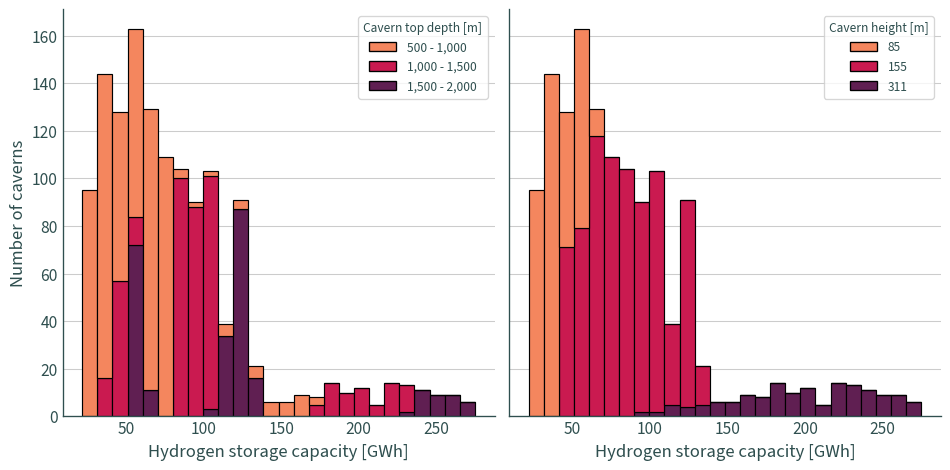

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
sns.histplot(
    caverns.rename(columns={"depth": "Cavern top depth [m]"}).sort_values(
        "TopDepthSeabed"
    ),
    x="capacity",
    hue="Cavern top depth [m]",
    palette="rocket_r",
    multiple="stack",
    alpha=1,
    ax=axes[0],
)
sns.histplot(
    caverns.rename(columns={"height": "Cavern height [m]"}).sort_values(
        "Thickness"
    ),
    x="capacity",
    hue="Cavern height [m]",
    palette="rocket_r",
    multiple="stack",
    alpha=1,
    ax=axes[1],
)
axes[0].set_xlabel("Hydrogen storage capacity [GWh]")
axes[1].set_xlabel("Hydrogen storage capacity [GWh]")
axes[0].grid(which="major", axis="y")
axes[1].grid(which="major", axis="y")
axes[0].set_ylabel("Number of caverns")
sns.despine()
plt.tight_layout()
plt.show()

## Maps

In [30]:
# create exclusion buffer
buffer = pd.concat([wells_b, shipwrecks_b, shipping_b, cables_b]).dissolve()

In [31]:
def plot_map_alt(dat_xr, cavern_df, zones_gdf, classes, colours, labels):
    """
    Helper function to plot caverns within the zones of interest
    """

    plt.figure(figsize=(20, 11.5))
    axis = plt.axes(projection=ccrs.epsg(rd.CRS))
    legend_handles = []

    # halite boundary - use buffering to smooth the outline
    shape = rd.halite_shape(dat_xr=dat_xr).buffer(1000).buffer(-1000)
    shape.plot(
        ax=axis,
        edgecolor="darkslategrey",
        color="none",
        linewidth=2,
        alpha=0.5,
        zorder=2,
    )
    legend_handles.append(
        mpatches.Patch(
            facecolor="none",
            linewidth=2,
            edgecolor="darkslategrey",
            label="Kish Basin boundary",
            alpha=0.5,
        )
    )

    zones_gdf.plot(
        ax=axis, zorder=1, linewidth=0, facecolor="white", alpha=0.45
    )
    zones_gdf.plot(
        ax=axis,
        zorder=2,
        edgecolor="slategrey",
        linestyle="dotted",
        linewidth=1.25,
        facecolor="none",
    )
    legend_handles.append(
        mpatches.Patch(
            facecolor="none",
            linestyle="dotted",
            edgecolor="slategrey",
            label="Feasible area",
            linewidth=1.25,
        )
    )

    pd.concat([buffer, wind_farms]).dissolve().clip(shape).plot(
        ax=axis,
        facecolor="none",
        linewidth=0.65,
        edgecolor="slategrey",
        zorder=2,
        alpha=0.5,
        hatch="//",
    )
    legend_handles.append(
        mpatches.Patch(
            facecolor="none",
            hatch="//",
            edgecolor="slategrey",
            label="Exclusion area",
            alpha=0.65,
            linewidth=0.5,
        )
    )

    legend_handles.append(
        mpatches.Patch(
            label="Hydrogen storage \ncapacity [GWh]", visible=False
        )
    )

    for x, y, z in zip(classes, colours, labels):
        if x == 0:
            c = cavern_df[cavern_df["capacity"] < x + 40]
        elif x == 160:
            c = cavern_df[cavern_df["capacity"] >= x]
        else:
            c = cavern_df[
                (cavern_df["capacity"] >= x) & (cavern_df["capacity"] < x + 40)
            ]
        for df, markersize in zip(
            [
                c[c["depth"] == "500 - 1,000"],
                c[c["depth"] == "1,000 - 1,500"],
                c[c["depth"] == "1,500 - 2,000"],
            ],
            [20, 50, 20],
        ):
            if len(df) > 0:
                df.centroid.plot(
                    ax=axis,
                    zorder=3,
                    linewidth=0,
                    marker=".",
                    markersize=markersize,
                    color=sns.color_palette("flare", 256)[y],
                )
        legend_handles.append(
            mpatches.Patch(
                facecolor=sns.color_palette("flare", 256)[y], label=z
            )
        )

    legend_handles.append(
        mpatches.Patch(label="Cavern top depth [m]", visible=False)
    )
    for markersize, label in zip(
        [6, 3], ["1,000 - 1,500", "500 - 1,000 or \n1,500 - 2,000"]
    ):
        legend_handles.append(
            Line2D(
                [0],
                [0],
                marker=".",
                linewidth=0,
                label=label,
                color="darkslategrey",
                markersize=markersize,
            )
        )

    plt.xlim(shape.bounds["minx"][0] - 1000, shape.bounds["maxx"][0] + 1000)
    plt.ylim(shape.bounds["miny"][0] - 1000, shape.bounds["maxy"][0] + 1000)

    cx.add_basemap(
        axis, crs=rd.CRS, source=cx.providers.CartoDB.VoyagerNoLabels
    )
    axis.gridlines(
        draw_labels={"bottom": "x", "left": "y"},
        alpha=0.25,
        color="darkslategrey",
    )
    axis.add_artist(
        ScaleBar(1, box_alpha=0, location="lower right", color="darkslategrey")
    )
    plt.legend(
        loc="lower right",
        bbox_to_anchor=(1, 0.05),
        handles=legend_handles,
        fontsize=11.5,
    )

    plt.tight_layout()
    plt.show()

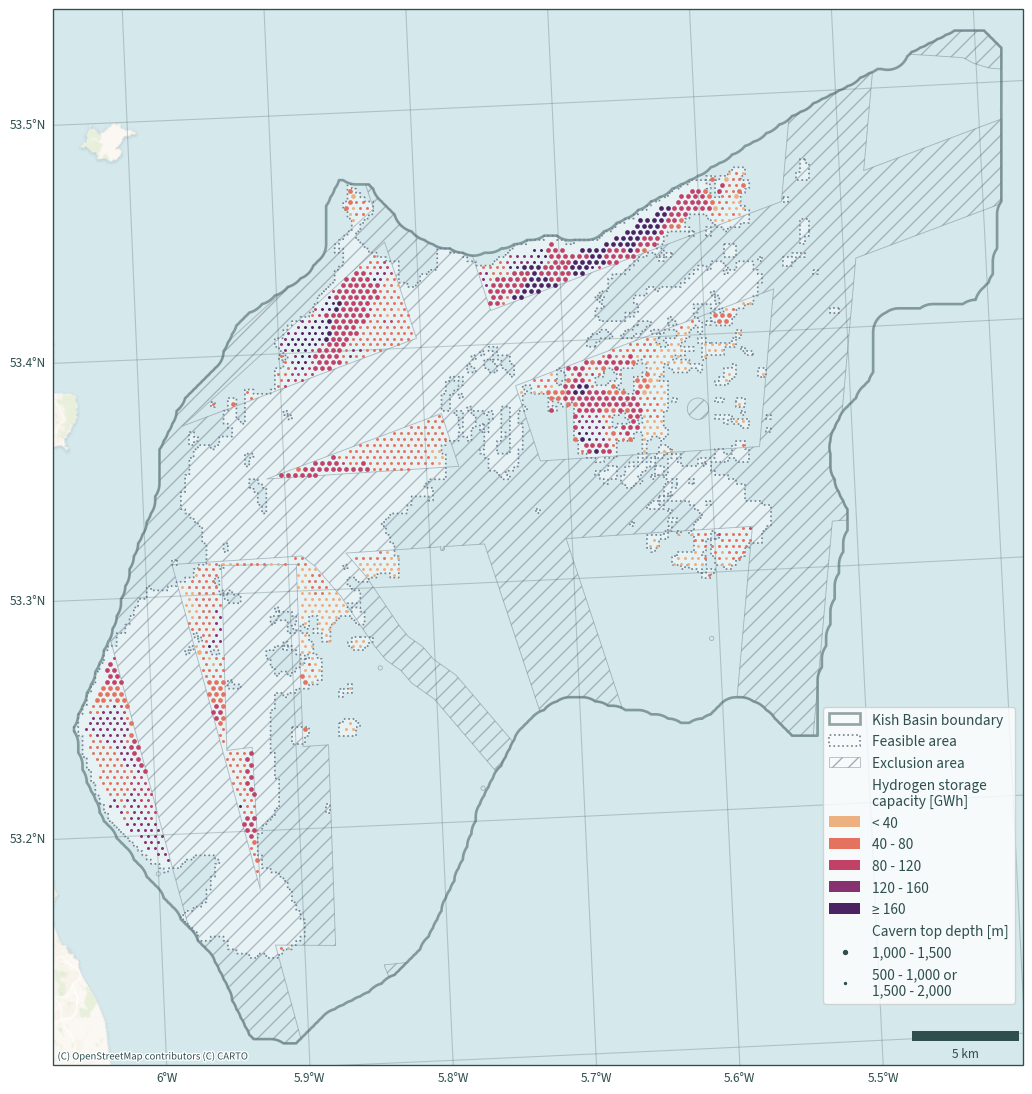

In [32]:
plot_map_alt(
    ds,
    caverns,
    zones,
    [40 * n for n in range(5)],
    [0] + [int(256 / 4) + int(256 / 4) * n - 1 for n in range(4)],
    ["< 40", "40 - 80", "80 - 120", "120 - 160", "≥ 160"],
)

## Restrict cavern height to 155 m

In [33]:
# height = 85 m, 500 m <= depth <= 2,000 m, diameter = 80 m,
# separation = 320 m
zones, zds = fns.zones_of_interest(
    dat_xr=ds, constraints={"height": 155, "min_depth": 500, "max_depth": 2000}
)

In [34]:
caverns, caverns_excl = fns.generate_caverns_with_constraints(
    zones_gdf=zones,
    zones_ds=zds,
    dat_extent=extent,
    exclusions={
        "wells": wells_b,
        "wind_farms": wind_farms,
        "shipwrecks": shipwrecks_b,
        "shipping": shipping_b,
        "cables": cables_b,
        "edge": edge_buffer,
    },
)

Without constraints...
Number of potential caverns: 2,471
------------------------------------------------------------
Exclude salt formation edges...
Number of potential caverns: 2,413
Caverns excluded: 2.35%
------------------------------------------------------------
Exclude frequent shipping routes...
Number of potential caverns: 1,019
Caverns excluded: 58.76%
------------------------------------------------------------
Exclude subsea cables...
Number of potential caverns: 1,003
Caverns excluded: 59.41%
------------------------------------------------------------
Exclude wind farms...
Number of potential caverns: 852
Caverns excluded: 65.52%
------------------------------------------------------------
Exclude exploration wells...
Number of potential caverns: 852
Caverns excluded: 65.52%
------------------------------------------------------------
Exclude shipwrecks...
Number of potential caverns: 852
Caverns excluded: 65.52%
---------------------------------------------------------

In [35]:
# label caverns by height and depth
caverns = fns.label_caverns(
    cavern_df=caverns,
    heights=[155],
    depths={"min": 500, "min_opt": 1000, "max_opt": 1500, "max": 2000},
)

In [36]:
caverns["cavern_volume"] = cap.cavern_volume(height=caverns["cavern_height"])
caverns["cavern_volume"] = cap.corrected_cavern_volume(
    v_cavern=caverns["cavern_volume"]
)

caverns["t_mid_point"] = cap.temperature_cavern_mid_point(
    height=caverns["cavern_height"], depth_top=caverns["cavern_depth"]
)

(
    caverns["p_operating_min"],
    caverns["p_operating_max"],
) = cap.pressure_operating(thickness_overburden=caverns["TopDepthSeabed"])

caverns["rho_min"], caverns["rho_max"] = cap.density_hydrogen_gas(
    p_operating_min=caverns["p_operating_min"],
    p_operating_max=caverns["p_operating_max"],
    t_mid_point=caverns["t_mid_point"],
)

(
    caverns["working_mass"],
    caverns["mass_operating_min"],
    caverns["mass_operating_max"],
) = cap.mass_hydrogen_working(
    rho_h2_min=caverns["rho_min"],
    rho_h2_max=caverns["rho_max"],
    v_cavern=caverns["cavern_volume"],
)

caverns["capacity"] = cap.energy_storage_capacity(
    m_working=caverns["working_mass"]
)

In [37]:
caverns.drop(
    [
        "x",
        "y",
        "TopTWT",
        "BaseDepth",
        "TopDepth",
        "BaseDepthSeabed",
        "height",
        "cavern_height",
    ],
    axis=1,
).describe()

,Thickness,TopDepthSeabed,cavern_depth,cavern_volume,t_mid_point,p_operating_min,p_operating_max,rho_min,rho_max,working_mass,mass_operating_min,mass_operating_max,capacity
count,852.000000,852.000000,852.000000,852.000000,852.000000,8.520000e+02,8.520000e+02,852.000000,852.000000,8.520000e+02,8.520000e+02,8.520000e+02,852.000000
mean,344.507865,1046.355139,1126.355139,326452.980096,328.294568,7.714346e+06,2.057159e+07,5.362542,13.283274,2.585747e+06,1.750618e+06,4.336365e+06,86.162828
std,70.252151,400.360820,400.360820,0.000000,15.013531,2.827829e+06,7.540876e+06,1.653503,3.823588,7.086511e+05,5.397909e+05,1.248222e+06,23.613828
min,245.000700,420.214316,500.214316,326452.980096,304.814287,3.291788e+06,8.778101e+06,2.569076,6.638388,1.328439e+06,8.386824e+05,2.167122e+06,44.266548
25%,291.084000,710.202879,790.202879,326452.980096,315.688858,5.340035e+06,1.424009e+07,3.979761,10.099535,1.997818e+06,1.299205e+06,3.297023e+06,66.571747
50%,336.202900,1000.569379,1080.569379,326452.980096,326.577602,7.390952e+06,1.970920e+07,5.268949,13.149784,2.572722e+06,1.720064e+06,4.292786e+06,85.728823
75%,380.278650,1333.040736,1413.040736,326452.980096,339.045278,9.739263e+06,2.597137e+07,6.612434,16.218697,3.135993e+06,2.158649e+06,5.294642e+06,104.498263
max,754.985800,1919.031682,1999.031682,326452.980096,361.019938,1.387823e+07,3.700863e+07,8.689494,20.759546,3.940304e+06,2.836711e+06,6.777016e+06,131.299694


In [38]:
# cavern volumes
list(caverns["cavern_volume"].unique())

[326452.98009604175]

In [39]:
# total capacity
caverns[["capacity"]].sum().iloc[0]

73410.72950384645

In [40]:
# total capacity at various depth/height combinations
s = caverns.groupby(["height", "depth"], sort=False)[["capacity"]].sum()
s["%"] = s["capacity"] / caverns[["capacity"]].sum().iloc[0] * 100
s

capacity          %
height depth                                 
155    1,000 - 1,500  30741.388312  41.875879
       500 - 1,000    23105.443025  31.474204
       1,500 - 2,000  19563.898167  26.649917

In [41]:
# total volume at various depth/height combinations
s = caverns.groupby(["height", "depth"], sort=False)[["cavern_volume"]].sum()
s["%"] = s["cavern_volume"] / caverns[["cavern_volume"]].sum().iloc[0] * 100
s

cavern_volume          %
height depth                                  
155    1,000 - 1,500   1.060972e+08  38.145540
       500 - 1,000     1.191553e+08  42.840376
       1,500 - 2,000   5.288538e+07  19.014085

In [42]:
# number of caverns
s = caverns.groupby(["height", "depth"], sort=False)[["cavern_volume"]].count()
s["%"] = s["cavern_volume"] / len(caverns) * 100
s

cavern_volume          %
height depth                                  
155    1,000 - 1,500            325  38.145540
       500 - 1,000              365  42.840376
       1,500 - 2,000            162  19.014085

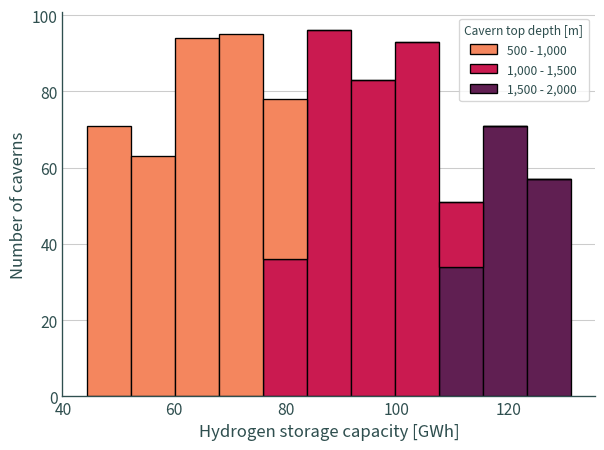

In [43]:
ax = sns.histplot(
    caverns.rename(columns={"depth": "Cavern top depth [m]"}).sort_values(
        "TopDepthSeabed"
    ),
    x="capacity",
    hue="Cavern top depth [m]",
    palette="rocket_r",
    multiple="stack",
    alpha=1,
)
ax.set_xlabel("Hydrogen storage capacity [GWh]")
ax.grid(which="major", axis="y")
ax.set_ylabel("Number of caverns")
sns.despine()
plt.tight_layout()
plt.show()

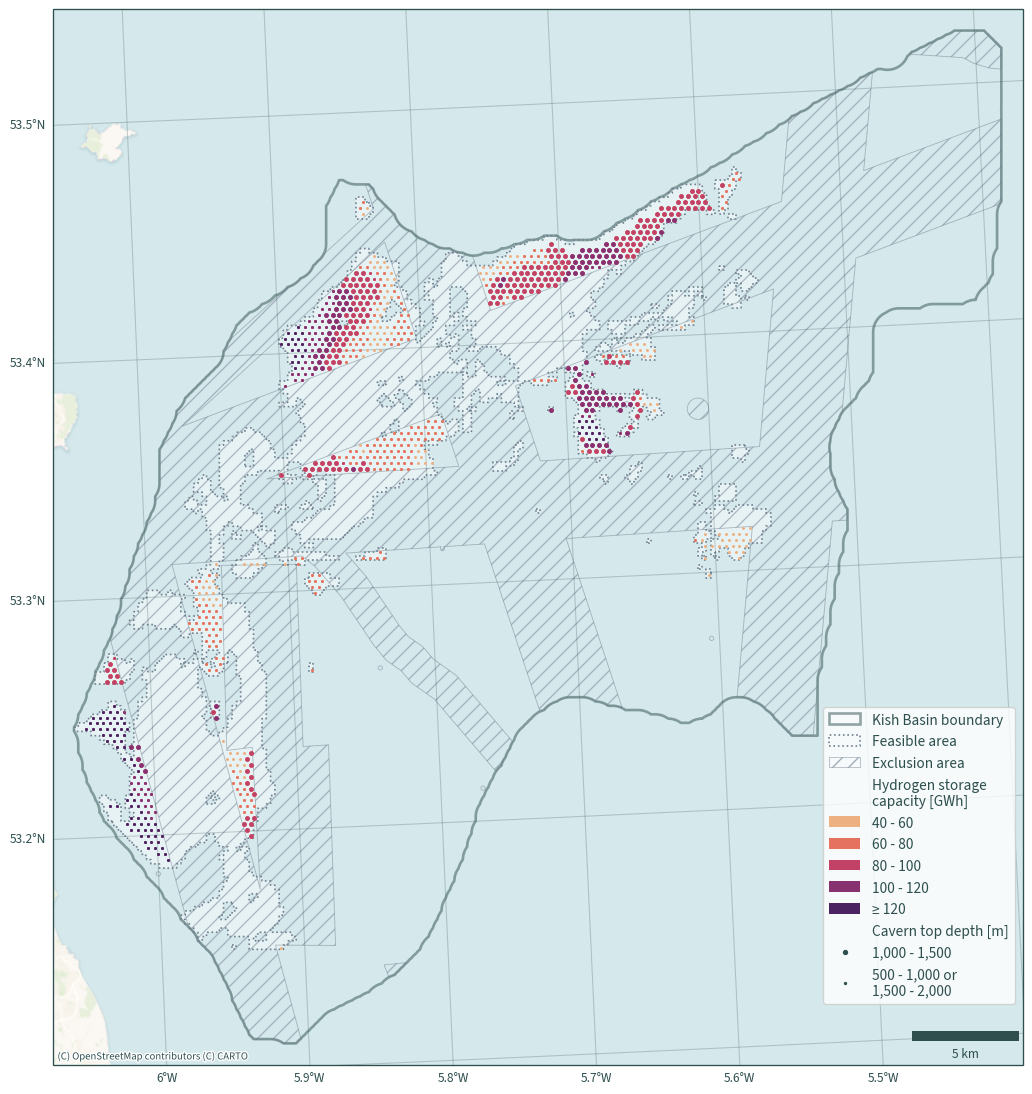

In [44]:
plot_map_alt(
    ds,
    caverns,
    zones,
    [20 + 20 * n for n in range(1, 6)],
    [0] + [int(256 / 4) + int(256 / 4) * n - 1 for n in range(4)],
    ["40 - 60", "60 - 80", "80 - 100", "100 - 120", "≥ 120"],
)